# Contributions comparing plot

compare_plot is a method that displays scatter plot of contributions of several individuals.<br />
The purpose of these representations is to understand where the difference of predictions of several indivuals stems from.<br />

<b>This tutorial </b>presents the different parameters you can use in compare_plot to tune output.

Contents:
- Loading dataset and fitting a model.

- Regression case: Specify the target modality to display.

- Input parameters

- Classification case


Data from Kaggle: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

## Building Supervized Model

#### First Step : Load house prices data

In [2]:
from shapash.data.data_loader import data_loading
house_df, house_dict = data_loading('house_prices')
y_df = house_df['SalePrice'].to_frame()
X_df = house_df[house_df.columns.difference(['SalePrice'])]

In [3]:
X_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,3,Single-family Detached,Typical - slight dampness allowed,No Exposure/No Basement,706,0,Good Living Quarters,...,Warranty Deed - Conventional,0,Paved,8,856,"All public Utilities (E,G,W,& S)",0,2003,2003,2008
2,1262,0,0,3,Single-family Detached,Typical - slight dampness allowed,Good Exposure,978,0,Average Living Quarters,...,Warranty Deed - Conventional,0,Paved,6,1262,"All public Utilities (E,G,W,& S)",298,1976,1976,2007
3,920,866,0,3,Single-family Detached,Typical - slight dampness allowed,Mimimum Exposure,486,0,Good Living Quarters,...,Warranty Deed - Conventional,0,Paved,6,920,"All public Utilities (E,G,W,& S)",0,2001,2002,2008
4,961,756,0,3,Single-family Detached,Good,No Exposure/No Basement,216,0,Average Living Quarters,...,Warranty Deed - Conventional,0,Paved,7,756,"All public Utilities (E,G,W,& S)",0,1915,1970,2006
5,1145,1053,0,4,Single-family Detached,Typical - slight dampness allowed,Average Exposure,655,0,Good Living Quarters,...,Warranty Deed - Conventional,0,Paved,9,1145,"All public Utilities (E,G,W,& S)",192,2000,2000,2008


#### Second step : Encode the categorical variables

In [4]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df)

X_df = encoder.transform(X_df)

## Regression case

#### Third step : Get your dataset ready and fit your model

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, train_size=0.75, random_state=1)

In [6]:
regressor = CatBoostRegressor(n_estimators=50).fit(Xtrain, ytrain, verbose=False)

In [7]:
y_pred = pd.DataFrame(regressor.predict(Xtest), columns=['pred'], index=Xtest.index)

#### Declare and compile your SmartExplainer explainer

In [8]:
from shapash import SmartExplainer

In [9]:
xpl = SmartExplainer(
    model=regressor,
    preprocessing=encoder, # Optional: compile step can use inverse_transform method
    features_dict=house_dict  # Optional parameter, dict specifies label for features name 
) 

In [10]:
house_dict['MSZoning']

'General zoning classification'

In [11]:
xpl.compile(
    x=Xtest,
    y_pred=y_pred # Optional
)

Backend: Shap TreeExplainer


### Compare_plot

Now that your explainer is ready, you can use the compare_plot to understand how two (or more) individuals are different.

For example, if you want to compare the first two individuals of the `Xtest` dataset, you have several ways to do it :

- you can use the `row_num` parameter by using `row_num = [0, 1]`

- You can also directly use the indexes, by `index = [Xtest.index[0], Xtest.index[1]]`

- You can also use directly the index numbers : `index = [259, 268]`

The result of each the methods above is the same :

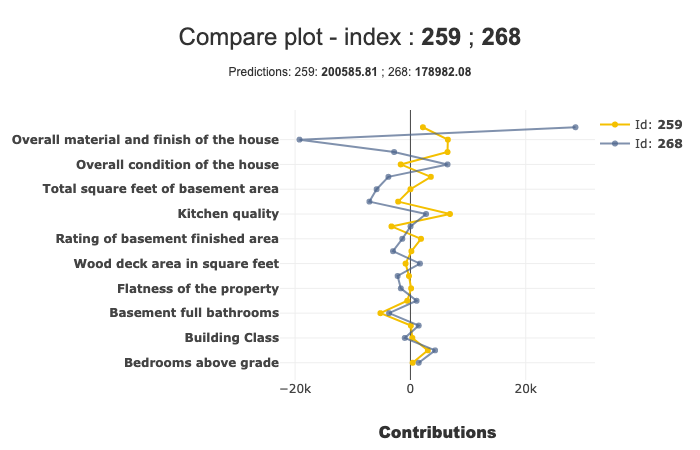

In [12]:
xpl.plot.compare_plot(index=[Xtest.index[0], Xtest.index[1]])

In this example, we can see that the 'Ground living area square feet' contributes a lot more for <b>Id 268</b> than <b>Id 259</b>.

We can see more details of a specific point on hover. 

#### Number of features displayed

By default, the number of features displayed by the compare_plot is 20. You can modify it with the `max_features` parameter. You can also compare more than 2 individuals:

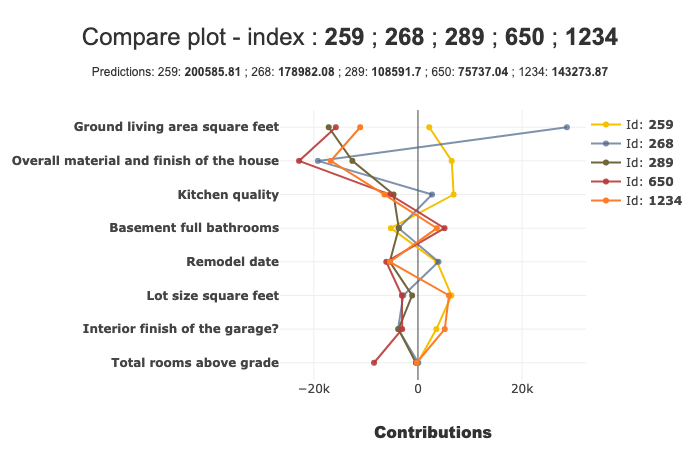

In [13]:
xpl.plot.compare_plot(row_num=[0, 1, 2, 3, 4], max_features=8)

You can also decide whether or not showing the prediction in subtitle, with the `show_predict` parameter.

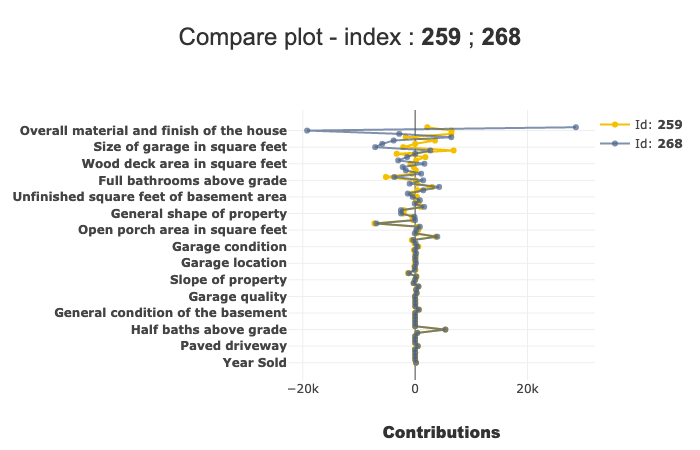

In [14]:
xpl.plot.compare_plot(row_num=[0, 1], show_predict=False, max_features=100)

## Classification case

Transform our use case into classification:

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
ytrain['PriceClass'] = ytrain['SalePrice'].apply(lambda x: 1 if x < 150000 else (3 if x > 300000 else 2))
label_dict = { 1 : 'Cheap', 2 : 'Moderately Expensive', 3 : 'Expensive' }

In [17]:
clf = RandomForestClassifier(n_estimators=50).fit(Xtrain,ytrain['PriceClass'])
y_pred_clf = pd.DataFrame(clf.predict(Xtest), columns=['pred'], index=Xtest.index)

#### Declare new SmartExplainer dedicated to classification problem 

In [18]:
xplclf = SmartExplainer(
    model=clf,
    preprocessing=encoder,
    features_dict=house_dict, 
    label_dict=label_dict      # Optional parameters: display explicit output
) 

In [19]:
xplclf.compile(
    x=Xtest,
    y_pred=y_pred_clf
)

Backend: Shap TreeExplainer


#### Use label parameter of compare_plot parameter to select the explanation you want

with `label` parameter, you can specify explicit label or label number.

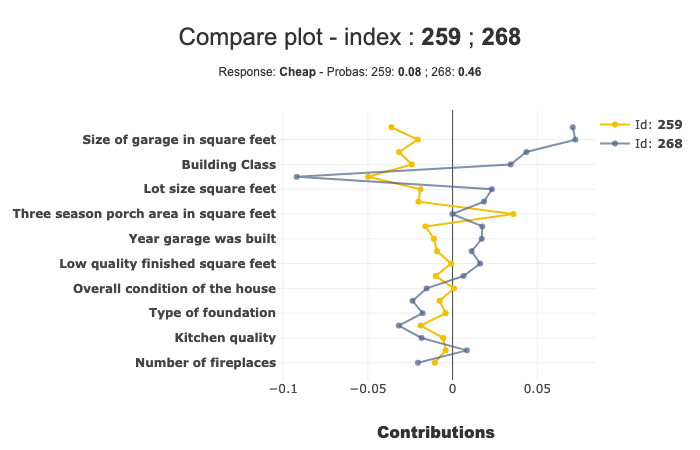

In [20]:
xplclf.plot.compare_plot(row_num=[0, 1], label=1) # Equivalent to label = 'Cheap'

By default, if `label` parameter isn't mentioned, the last label will be used.

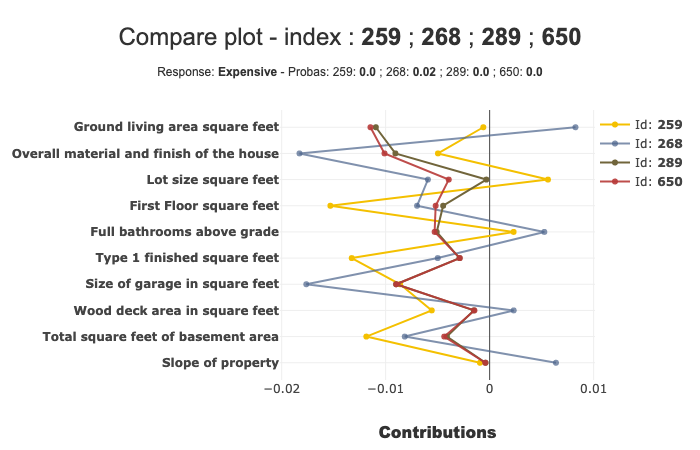

In [21]:
xplclf.plot.compare_plot(row_num=[0, 1, 2, 3], max_features=10)